AutoRegressive Integrated Moving Average

AutoRegressive = uses past values to predict future
Integrated = Data is stationary, it calculates the differences so that data doesn't trend upward, rather it stays consistent.
Ex.
Original prices: [100, 102, 105, 108, 110, 113, 115, 118, 120, 123]
First differences (returns): [2, 3, 3, 2, 3, 2, 3, 2, 3]

Moving Average = Uses the error of past predictions to calculate future values.

ARIMA:

- handles time series nature. Stock prices heavily depend on past data. 
- captures momentum, and mean reversion, does so by using 

ARIMA captures momentum and mean reversion because it uses past values and past residuals to predict future values 

ARIMA has 3 parameters:
p = past values to use (AR)
d = calculate the difference (I)
q = past errors to use (MA)


ARIMA is composed of 3 parts that you can choose to use or not to use.

ARIMA(1, 1, 1) is the order, it takes the amounts from 1 sample ago for each AR and MA. 2 would be 2 samples ago.

AR = almost like dynamic programming, take prior value prediction, and current prediction
MA = same thing but for error.
You add the two.

The HAT is the predicted value. 

How do you set the ordering for ARIMA ?
Auto coorelation, and predictive auto coorelation.

ACR measures how coorelated a time series is with its own past values at different lags. Helps determine the MA. / q.

PACF measures coorelation between the series and a lagged value, after removing the effects of all shorter lags. Helps determine the direct effect of lags by accounting for intermediate lags coorelation. Helps determine the AR part.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [13]:
data = yf.download("XUS.TO", start="2020-01-01", end="2025-09-04")
data = data[["Close"]]
print(data.head())

/var/folders/8n/wwy51hvj1x96xvwxlmv1_lvh0000gn/T/ipykernel_17583/1945755231.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("XUS.TO", start="2020-01-01", end="2025-09-04")
[*********************100%***********************]  1 of 1 completed

Price           Close
Ticker         XUS.TO
Date                 
2020-01-02  24.514065
2020-01-03  24.382874
2020-01-06  24.396933
2020-01-07  24.420359
2020-01-08  24.579659


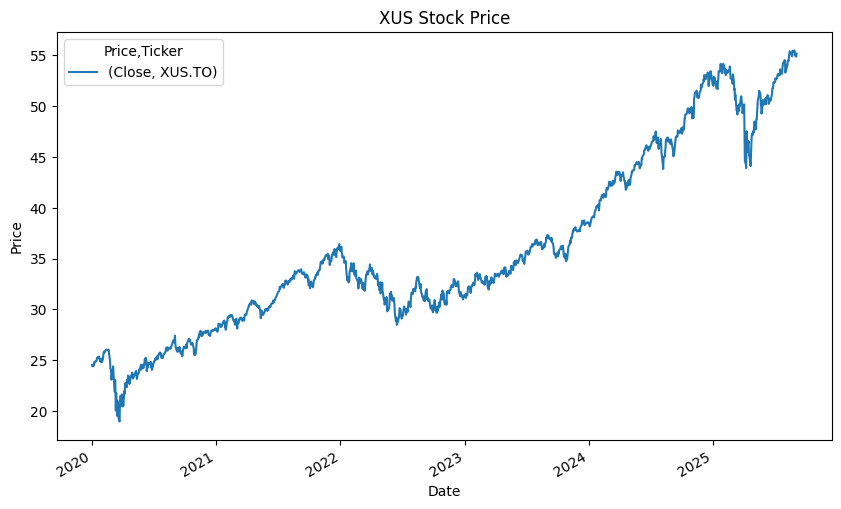

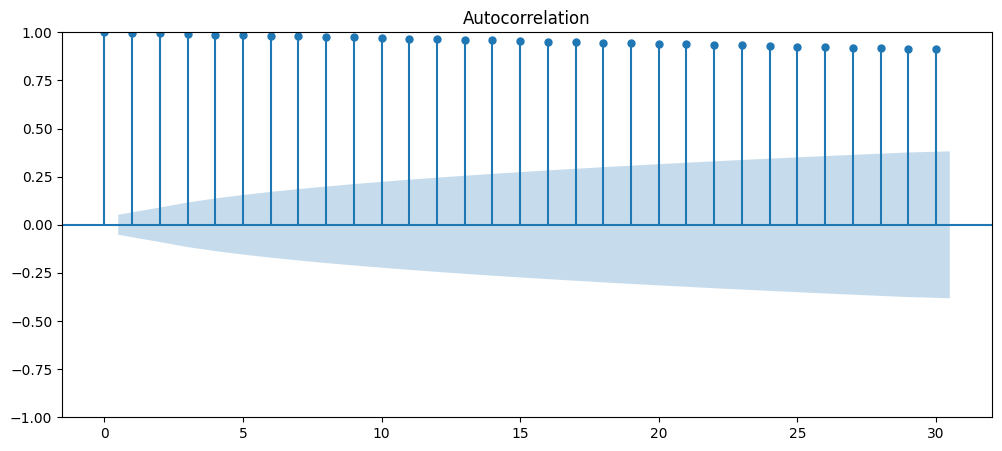

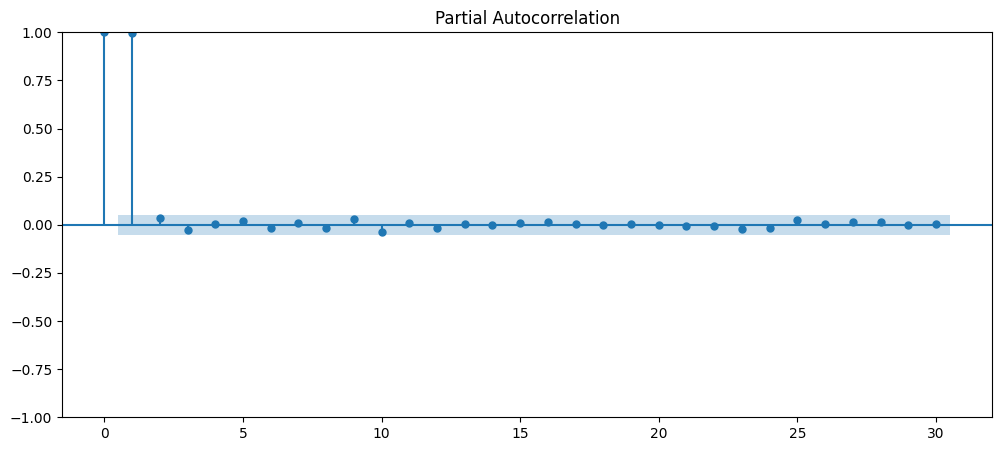

In [27]:
data.plot(figsize=(10, 6))
plt.title("XUS Stock Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(data, lags=30, ax=plt.gca())
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(data, lags=30, ax=plt.gca())
plt.show()



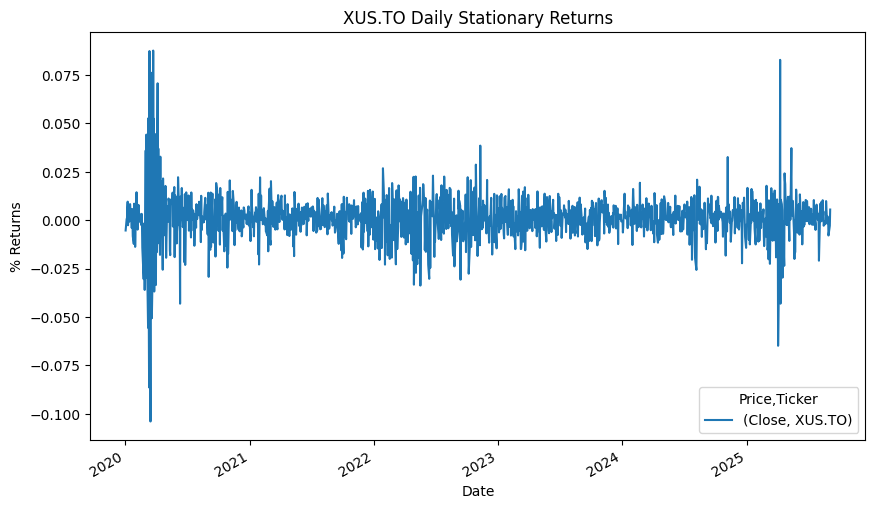

In [15]:
stationary_returns = data.pct_change().dropna()
stationary_returns.plot(figsize=(10, 6))
plt.title("XUS.TO Daily Stationary Returns")
plt.xlabel("Date")
plt.ylabel("% Returns")
plt.show()

In [ ]:
# from above MA can be ignored by setting it to 0 or 1 and AR is 2, since we calculate the pct change, we set I to 0

model = ARIMA(stationary_returns, order=(2, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           Close_XUS.TO   No. Observations:                 1423
Model:                 ARIMA(2, 0, 1)   Log Likelihood                4317.462
Date:                Fri, 05 Sep 2025   AIC                          -8624.924
Time:                        20:06:32   BIC                          -8598.621
Sample:                             0   HQIC                         -8615.099
                               - 1423                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      2.244      0.025    8.08e-05       0.001
ar.L1         -0.5890      0.118     -5.007      0.000      -0.820      -0.358
ar.L2         -0.0031      0.034     -0.091      0.9

/Users/tylerfarkas/Documents/repos/finance-ml-lab/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tylerfarkas/Documents/repos/finance-ml-lab/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tylerfarkas/Documents/repos/finance-ml-lab/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/Users/tylerfarkas/Documents/repos/finance-ml-lab/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tylerfarkas/Documents/repos/finance-ml-lab/venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


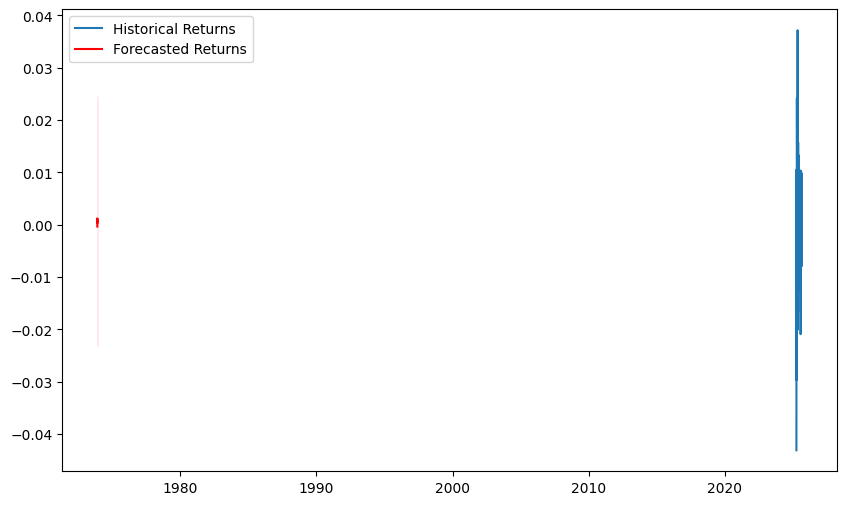

In [29]:
forecast = model_fit.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(stationary_returns.index[-100:], stationary_returns[-100:], label="Historical Returns")
plt.plot(forecast_mean.index, forecast_mean, label="Forecasted Returns", color="red")
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="pink", alpha=0.3)

plt.legend()
plt.show()


In [30]:
forecast_df = forecast.summary_frame()

for date, row in forecast_df.iterrows():
    mean = row["mean"]
    lower = row["mean_ci_lower"]
    upper = row["mean_ci_upper"]
    print(f"{date}: Expected return = {mean:.4f}, 95% CI = [{lower:.4f}, {upper:.4f}]")

1423: Expected return = -0.0004, 95% CI = [-0.0232, 0.0225]
1424: Expected return = 0.0012, 95% CI = [-0.0221, 0.0245]
1425: Expected return = 0.0003, 95% CI = [-0.0231, 0.0237]
1426: Expected return = 0.0008, 95% CI = [-0.0227, 0.0243]
1427: Expected return = 0.0005, 95% CI = [-0.0230, 0.0240]
1428: Expected return = 0.0007, 95% CI = [-0.0228, 0.0242]
1429: Expected return = 0.0006, 95% CI = [-0.0229, 0.0241]
1430: Expected return = 0.0007, 95% CI = [-0.0229, 0.0242]
1431: Expected return = 0.0006, 95% CI = [-0.0229, 0.0241]
1432: Expected return = 0.0006, 95% CI = [-0.0229, 0.0242]
